In [1]:
import pandas as pd
from ast import literal_eval
import utils as ut
from importlib import reload
import os
from statannot import add_stat_annotation
import dna_features_translator_class as dftc
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr, mannwhitneyu, chi2_contingency
reload(ut)
PATH = os.getcwd()
TABLEU = mcolors.TABLEAU_COLORS

# Organisms to be excluded from the analysis
bad_orgs = ['Aldrichina_grahami', 'Rhopilema esculentum', 'Aphis fabae']
# Datasets to be excluded from the analysis
bad_datasets = ['AGos_transc3']
plt.style.use('default')



In [6]:
# Load the junction dataframe and remove bad orgs and datasets
junctions = pd.read_csv(os.path.join(PATH, 'junctions_filtered.csv'))
bad_orgs += [i for i in junctions.org.unique() if len(junctions.loc[(junctions.org == i) & (junctions.strand_switch == 'DSJ'), 'junc_tpm']) == 0] # Remove orgs with no DSJ junction expression
junctions = junctions.loc[~(junctions.org.isin(bad_orgs)), :]
junctions = junctions[~(junctions.dataset.isin(bad_datasets))]

# Load the final.csv dataframe and fix the gene order and organism names
org_db = pd.read_csv(os.path.join(os.path.dirname(os.path.dirname(PATH)), '01_Database_construction', 'DB_csvs', 'final.csv'))
org_db = org_db.dropna(subset = ['Gene_order'], axis = 0)
org_db.Gene_order = org_db.Gene_order.apply(literal_eval)
org_db.organism = org_db.organism.str.replace(' ', '_')
bad_orgs

['Aldrichina_grahami',
 'Rhopilema esculentum',
 'Aphis fabae',
 'Saccostrea_glomerata',
 'Caenorhabditis_brenneri',
 'Ciona_intestinalis',
 'Mytilus_galloprovincialis',
 'Schistosoma_mansoni',
 'Ruditapes_philippinarum',
 'Pomacea_canaliculata']

In [7]:
# Check which organisms have Alter_model gene organization
org_db['Alter_model'] = org_db.Gene_order.apply(ut.alter_cluster_model)
EXCEPTIONS = ['Aphis_fabae'] # Organisms to include in the Alter_model organization regardless of their actual mtDNA organization
org_db.at[org_db.organism.isin(EXCEPTIONS), 'Alter_model'] = True # Set the Alter_model column to True for these organisms

display(org_db[org_db.Alter_model == True].sample(3))

,organism,RefSeq,kingdom,phylum,class,order,family,genus,Gene_order,Gene_locations,Notes,tRNA_validation,Intron,Full,genetic_code,Haplotype,topology,not_valid,Alter_model
635,Anopheles_evansae,NC_037795.1,Metazoa,Arthropoda,Insecta,Diptera,Culicidae,Anopheles,"[-nad1, -trnL*, -rrnL, -trnV, -rrnS, trnI, -tr...","['11625:12582:-1', '12576:12642:-1', '12642:13...","['None', 'None', 'None', 'None', 'None', 'None...","['N', 'V', 'N', 'V', 'N', 'V', 'V', 'V', 'N', ...",False,True,5,NaN,circular,False,True
3972,Hypsosinga_pygmaea,NC_028078.1,Metazoa,Arthropoda,Arachnida,Araneae,Araneidae,Hypsosinga,"[-nad1, -trnL*, -rrnL, -trnV, -rrnS, -trnQ, tr...","['10737:11640:-1', '11649:11701:-1', '11701:12...","['None', 'None', 'None', 'None', 'None', 'None...","['N', 'V', 'N', 'V', 'N', 'V', 'V', 'N', 'V', ...",False,True,5,NaN,circular,True,True
7971,Stylatula_elongata,NC_018380.1,Metazoa,Cnidaria,Anthozoa,Pennatulacea,Virgulariidae,Stylatula,"[nad1, cob, nad6, nad3, nad4L, rrnL, nad2, nad...","['2834:3815:1', '3826:4987:1', '5005:5560:1', ...","['None', 'None', 'None', 'None', 'None', ""['16...","['N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', ...",False,True,4,NaN,circular,False,True


In [8]:
alter_juncs = pd.merge(left = org_db, right = junctions, how = 'inner', on = 'organism', suffixes = [None, '_'], indicator= True) # Merge the junction dataframe with the final.csv dataframe
display(alter_juncs[(alter_juncs['Alter_model'] == True) & (alter_juncs['phylum'] != 'Arthropoda')].sample(3))
display(alter_juncs.columns)

,organism,RefSeq,kingdom,phylum,class,order,family,genus,Gene_order,Gene_locations,...,Gene_order_,junc_deseq,left_tpm_raw,right_tpm_raw,left_rpkm_raw,right_rpkm_raw,junc_tpm_raw,junc_rpkm_raw,junc_type,_merge
13630,Physella_acuta,NC_023253.1,Metazoa,Mollusca,NaN,Gastropoda,Physidae,Physella,"[nad1, trnD, trnF, cox2, trnY, trnW, nad4L, tr...","['3612:4518:1', '4520:4590:1', '4600:4665:1', ...",...,"['nad1', 'trnD', 'trnF', 'cox2', 'trnY', 'trnW...",6.717488,28923.582511,152220.449160,14364.570395,75598.565863,12461.587938,1231.337757,A,both
9953,Octopus_bimaculoides,NC_029723.1,Metazoa,Mollusca,Cephalopoda,Octopoda,Octopodidae,Octopus,"[-nad1, -trnL, -trnL*, -rrnL, -trnV, -rrnS, -t...","['11049:11991:-1', '11991:12059:-1', '12058:12...",...,"['-nad1', '-trnL', '-trnL*', '-rrnL', '-trnV',...",5.758132,173743.722517,2475.848623,159692.032015,2275.611987,6347.697777,768.499888,A,both
9891,Octopus_bimaculoides,NC_029723.1,Metazoa,Mollusca,Cephalopoda,Octopoda,Octopodidae,Octopus,"[-nad1, -trnL, -trnL*, -rrnL, -trnV, -rrnS, -t...","['11049:11991:-1', '11991:12059:-1', '12058:12...",...,"['-nad1', '-trnL', '-trnL*', '-rrnL', '-trnV',...",7.551252,184013.283547,6439.998024,167637.696296,5866.894021,15481.372518,1853.852862,A,both


Index(['organism', 'RefSeq', 'kingdom', 'phylum', 'class', 'order', 'family',
       'genus', 'Gene_order', 'Gene_locations', 'Notes', 'tRNA_validation',
       'Intron', 'Full', 'genetic_code', 'Haplotype', 'topology', 'not_valid',
       'Alter_model', 'gpair', 'org', 'coexpression', 'left_tpm', 'right_tpm',
       'left_rpkm', 'right_rpkm', 'right_gene', 'left_gene', 'left_strand',
       'right_strand', 'neigh_freq', 'strand_switch', 'Chromosome',
       'junction_size', 'sum_around_junction', 'Position', 'last_Position',
       'count_Position', 'mean_RPM', 'median_RPM', 'mean_coverage',
       'median_coverage', 'mean_z', 'median_z', 'mean_ends_ratio',
       'max_ends_ratio', 'dataset', 'junc_counts', 'glengths', 'junc_tpm',
       'junc_rpkm', 'junc_tpm_z', 'junc_rpkm_z', 'left_z', 'right_z',
       'junc_tpm_mm', 'junc_rpkm_mm', 'left_mm', 'right_mm', 'exp_diff',
       'sample', 'kingdom_', 'phylum_', 'class_', 'order_', 'family_',
       'genus_', 'Gene_order_', 'junc_deseq'

There are 29 organisms in the database


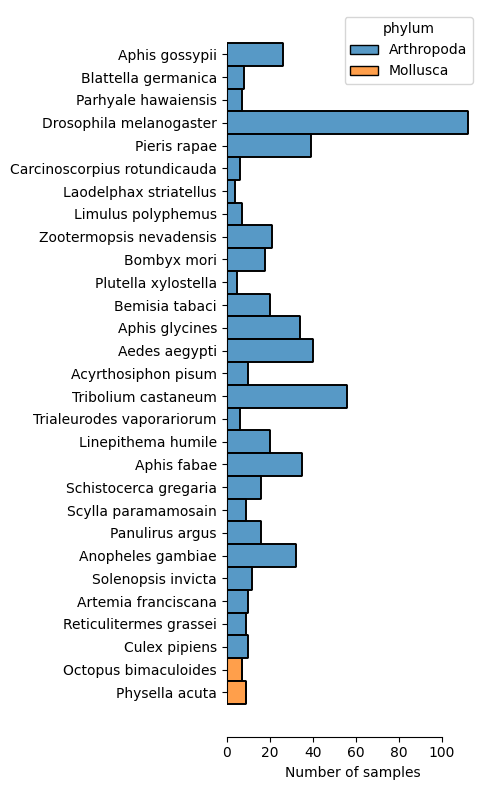

In [9]:
# Fig 5B - Plot the sample counts for the Alter_model organisms.
_, axes = plt.subplots(figsize = (5, 8))
temp = alter_juncs[alter_juncs['Alter_model'] == True].groupby('sample').agg({
    'org':'first', 'dataset':'first', 'gpair':'count', 'phylum':'first','class':'first', 'junc_tpm':'mean'})
temp.to_csv('alterjunc_sample_counts.csv')
temp = temp.sort_values(by = 'phylum', ascending = True)
temp = temp.apply(lambda x: x.astype('category'), axis = 1)

temp.org = temp.org.str.replace('_', ' ')
sns.histplot(data = temp, y = 'org', hue = 'phylum', multiple = 'stack', legend = True, ax = axes, discrete= True, )
plt.xticks(rotation = 90)

axes.set(ylabel = '', xlabel = 'Number of samples')
sns.despine(trim=True, offset=0)
print(f'There are {len(temp.org.unique())} organisms in the database')

plt.tight_layout()
plt.savefig(os.path.join('figures', 'fig_5b_alter_junc_samples.svg'), dpi = 300)


In [56]:
alter_juncs['norm_junc'] = alter_juncs['junc_tpm'] / alter_juncs[['left_tpm', 'right_tpm']].mean(axis = 1)
alter_juncs = alter_juncs[alter_juncs['junc_type'] != 'D']

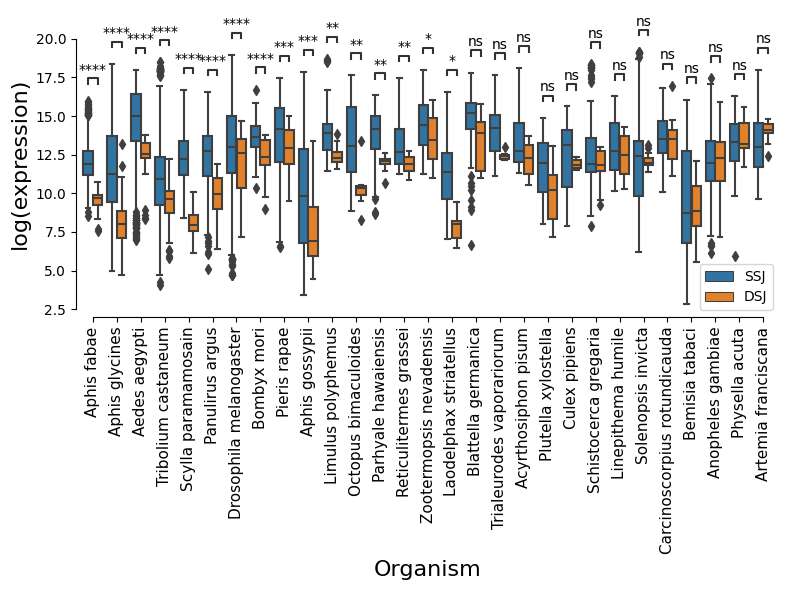

In [57]:
# Plot of log(expression) of DSJ vs. SSJ per organism for organisms with the AGC model
reload(ut)

ut.plot_y_per_x_by_hue(alter_juncs[alter_juncs['Alter_model'] == True], x = 'org', y = 'junc_tpm', figpath = os.path.join(PATH, 'figures', 'agb_org_exp_without_tail_tail.svg'), verbose = 0, multiple_test_correction=True)


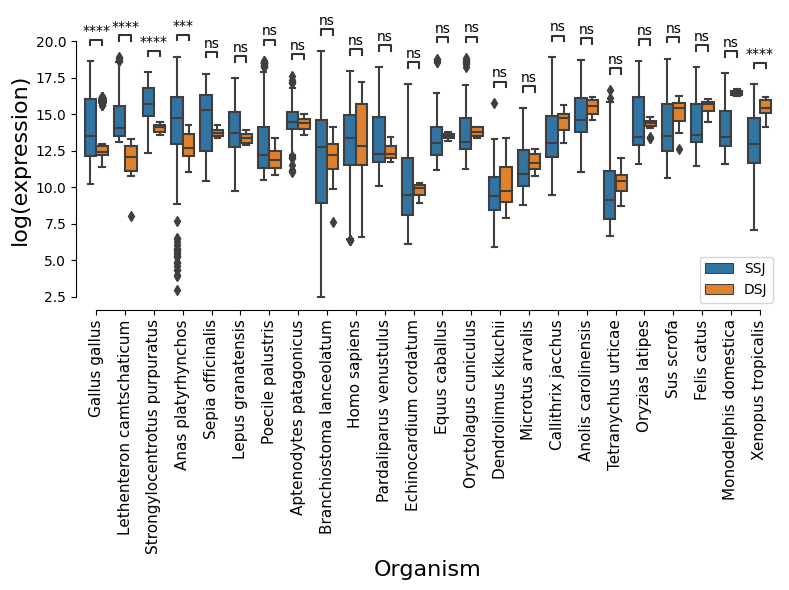

In [58]:
# Plot of log(expression) of DSJ vs. SSJ per organism for organisms without the AGC model
ut.plot_y_per_x_by_hue(alter_juncs[alter_juncs['Alter_model'] == False], x = 'org', y = 'junc_tpm', figpath = os.path.join(PATH, 'figures', 'non_agb_org_exp_without_tail_tail.svg'), verbose =0, multiple_test_correction = True, )



In [59]:
reload(ut)
# Calculate fold change between DSJ and SSJ for each organism
logfold_df = pd.DataFrame()
n = len(alter_juncs.org.unique())
alpha = 0.05 / n
for org in alter_juncs.org.unique():
    dsj_tpm = alter_juncs.loc[(alter_juncs.org == org) & (alter_juncs.strand_switch == 'DSJ'), 'junc_tpm'].values
    ssj_tpm = alter_juncs.loc[(alter_juncs.org == org) & (alter_juncs.strand_switch == 'SSJ'), 'junc_tpm'].values
    if len(dsj_tpm) == 0 or len(ssj_tpm) == 0:
        continue
    logfold_df.loc[org, 'log2FC'] = ut.log2fc(ssj_tpm, dsj_tpm)
    logfold_df.loc[org, 'log2FC_sd'] = ut.log2fc_sd(ssj_tpm, dsj_tpm)
    logfold_df.loc[org, 'pval'] = mannwhitneyu(ssj_tpm, dsj_tpm)[1]
    logfold_df.loc[org, 'Significant'] = True if logfold_df.loc[org, 'pval'] < alpha else False
    logfold_df.loc[org, 'alter_junc'] = 'AGB Organization' if alter_juncs.loc[(alter_juncs.org == org), 'Alter_model'].values[0] else 'Non-AGB Organization'
    logfold_df.loc[org, 'phylum'] = alter_juncs.loc[(alter_juncs.org == org), 'phylum'].values[0]
logfold_df.reset_index(inplace = True, drop = False)
logfold_df = logfold_df.rename(columns = {'index':'org'})
logfold_df.to_csv('logfold_df.csv')
logfold_df.head()


,org,log2FC,log2FC_sd,pval,Significant,alter_junc,phylum
0,Acyrthosiphon_pisum,0.141763,0.233247,2.830043e-02,False,AGB Organization,Arthropoda
1,Anas_platyrhynchos,0.126058,0.437064,1.667615e-05,True,Non-AGB Organization,Chordata
2,Aphis_fabae,0.357965,0.214358,1.086771e-27,True,AGB Organization,Arthropoda
3,Aphis_glycines,0.500939,0.454993,2.789121e-19,True,AGB Organization,Arthropoda
4,Aphis_gossypii,0.402975,0.690587,2.020335e-05,True,AGB Organization,Arthropoda


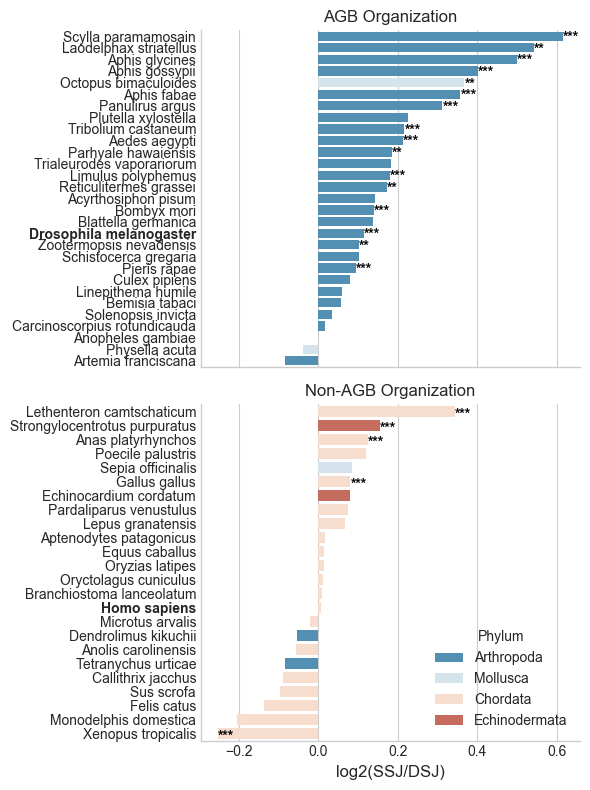

In [60]:
# Log2FC plot of DSJ vs. SSJ per organism for organisms with the AGC model

# Change plot style to classic
plt.style.use('seaborn-whitegrid')
# Create a plot of log2FC for each organism split by AGC model
logfold_df = logfold_df.sort_values(by = 'log2FC', ascending = False)
logfold_df = logfold_df.replace('_', ' ', regex = True)
g = sns.catplot(data = logfold_df, y = 'org', x = 'log2FC', hue = 'phylum',  kind = 'bar', col = 'alter_junc', legend = False, palette = 'RdBu_r', height = 4, aspect = 1.5, sharey = False, dodge = False, sharex = True, col_wrap = 1)
g.set_titles("{col_name}", fontsize = 12)
g.set_xlabels('log2(SSJ/DSJ)', fontsize = 12)
g.set_ylabels('', fontsize = 12)
# Set 'Drosophila melanogaster' and 'Homo sapiens' as bold
g.set_yticklabels(fontsize = 10)
# Set a specific label as bold KEEP THIS CODE
for i in range(2): # Iterate over the amount of axes in the facetgrid
    for tick in g.axes[i].get_yticklabels(): # Iterate over the y-axis labels
        if tick.get_text() in ['Drosophila melanogaster', 'Homo sapiens']: # Check if the label value is in the list 
            tick.set_fontweight('bold') # If it is, set the label as bold
        if tick.get_text() in logfold_df[logfold_df.Significant == True].org.unique():
            # Add an asterisk at the end of the bar
            # Get the y coordinate of the label
            y = tick.get_position()[1] + 0.5
            cur_lfc = logfold_df.loc[logfold_df.org == tick.get_text(), 'log2FC'].iloc[0]
            g.axes[i].text(x = cur_lfc, y = y, s = ut.convert_to_asterisk(logfold_df.loc[logfold_df.org == tick.get_text(), 'pval'].squeeze()), fontsize = 10, fontweight = 'bold', color = 'black')

# Add asterisks next to the columns if the log2 fc is significant (according to the Significant column)



g.despine()
plt.legend(title = 'Phylum', loc = 'lower right', fontsize = 10)
plt.tight_layout()



#plt.savefig(r'C:\Users\noam1\Desktop\The dynamics of the mitochondrial genome (paper prep)\figures\log2FC_by_alter_junc.svg', dpi = 300) # Save the figure

C:\Users\noam1\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


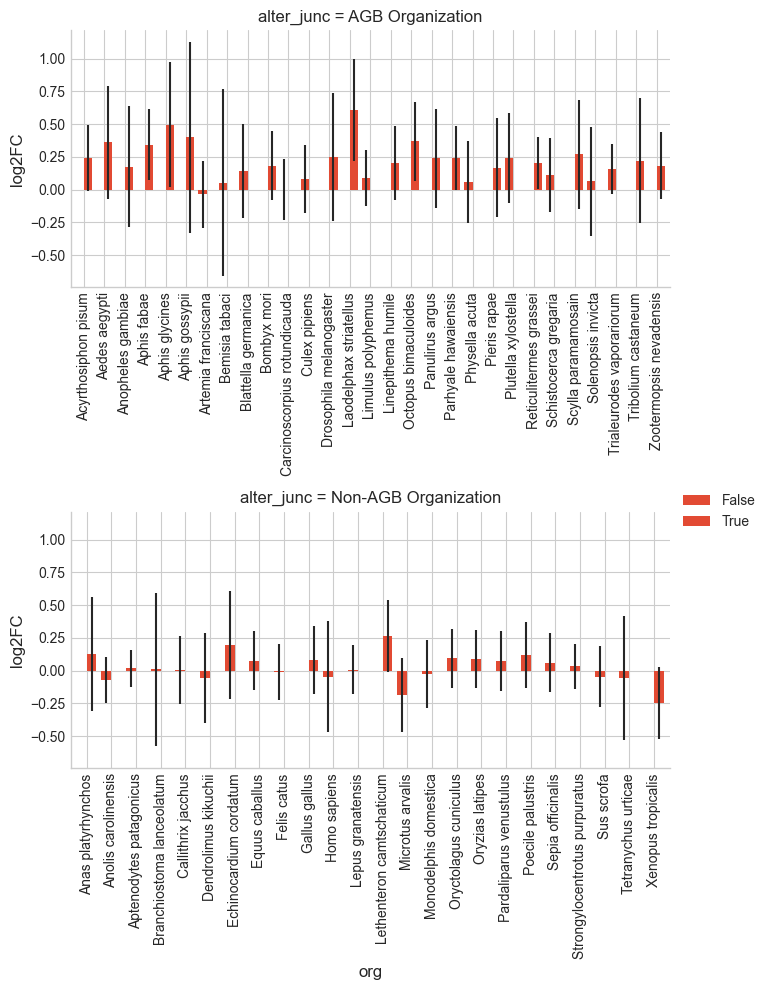

In [11]:
def errplot(x, y, yerr, hue, **kwargs):
    data = kwargs.pop('data')
    p = data.pivot_table(index=x, columns=hue, values=y, aggfunc='mean')
    err = data.pivot_table(index=x, columns=hue, values=yerr, aggfunc='mean')
    p.plot(kind='bar', yerr=err, ax=plt.gca(), **kwargs)


g = sns.FacetGrid(logfold_df, col='alter_junc', col_wrap=1, sharex=False, sharey=True, size=5, aspect=1.5)
g.map_dataframe(errplot, "org", "log2FC", "log2FC_sd", "Significant", width=0.8)
plt.subplots_adjust(right=0.90)
plt.legend(loc='center left', bbox_to_anchor=(1,1))
plt.show()



In [12]:
# Chi squared test to see if AGC model organisms tend to have more significant difference between DSJ and SSJ
reload(ut)
agc_model_sign_contig = ut.generate_2_x_2_conting(alter_juncs)
print(f'Contig table:\n\n   sign \nAGC{agc_model_sign_contig[0,:]}\n   {agc_model_sign_contig[1,:]}\n')
print(f'Expected table\n\n{chi2_contingency(agc_model_sign_contig, correction = True)[3]}\n')
print(f'P-value: {chi2_contingency(agc_model_sign_contig, correction = True)[1]}')

Contig table:

   sign 
AGC[19 10]
   [ 3 21]

Expected table

[[12.03773585 16.96226415]
 [ 9.96226415 14.03773585]]

P-value: 0.00029561872788747256


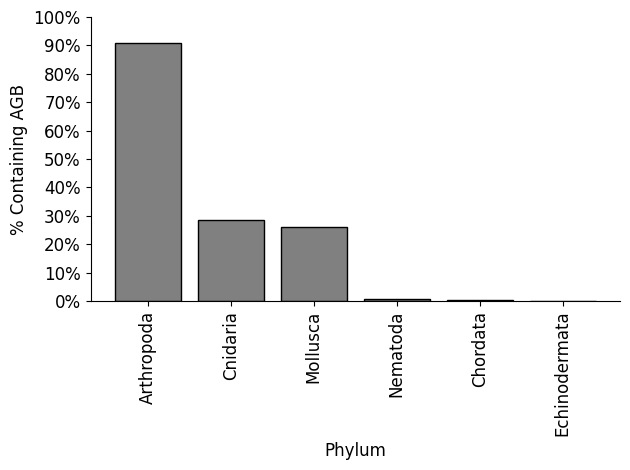

In [11]:
phs = ['Echinodermata', 'Mollusca', 'Nematoda', 'Chordata', 'Arthropoda', 'Cnidaria']

alter_per_phylum = org_db[org_db.phylum.isin(phs)].groupby('phylum').agg({'Alter_model' : 'mean'}).reset_index().sort_values('Alter_model', ascending = False)
alter_per_phylum.Alter_model = round(alter_per_phylum.Alter_model * 100, 2)

plt.bar(x = alter_per_phylum['phylum'].squeeze(), height = alter_per_phylum['Alter_model'].squeeze(), color = 'grey', align = 'center', edgecolor = 'black')
plt.yticks(ticks = list(range(0,101,10)), labels = [f'{i}%' for i in range(0,101,10)], fontsize = 12)
plt.xticks(rotation = 90, fontsize = 12)
plt.xlabel('Phylum', fontsize = 12)
plt.ylabel('% Containing AGB', fontsize = 12)
plt.ylim(0,100)
sns.despine()
plt.tight_layout()
plt.savefig(os.path.join('figures', 'agc_per_phylum.pdf'))


In [44]:
alter_per_class = org_db[org_db.phylum.isin(phs)].groupby('class').agg({'phylum':'first','Alter_model' : 'mean'}).reset_index().sort_values('Alter_model', ascending = False)
alter_per_class = alter_per_class[alter_per_class['Alter_model'] > 0.1]
alter_per_class.head(2)


,class,phylum,Alter_model
44,Remipedia,Arthropoda,1.0
41,Polyplacophora,Mollusca,1.0


In [57]:
AGB = alter_juncs[alter_juncs.organism == alter_juncs[alter_juncs['Alter_model'] == True].organism.sample(1).squeeze()]
NONAGB = alter_juncs[alter_juncs.organism == alter_juncs[alter_juncs['Alter_model'] == False].organism.sample(1).squeeze()]


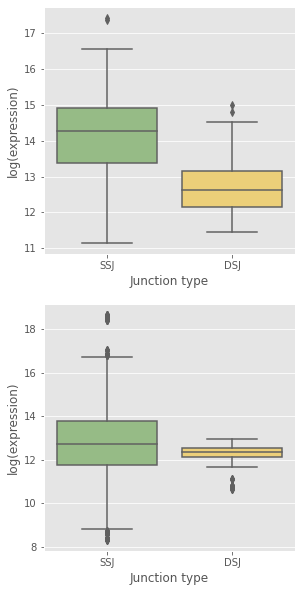

In [60]:

_, ax = plt.subplots(2,1, figsize = (4.5, 10))
st = ['DSJ', 'SSJ']
colors = ['#ffd966', '#93c47d']

palette = {st[i]:colors[i] for i in range(2)}
for i, df in enumerate([AGB, NONAGB]):
    sns.boxplot(ax = ax[i], data = df, x = 'strand_switch', y = 'junc_tpm', palette = palette)
    ax[i].set_ylabel('log(expression)')
    ax[i].set_xlabel('Junction type')

plt.savefig(r'C:\Users\noam1\Desktop\The dynamics of the mitochondrial genome (paper prep)\figures\agc_junc_type.pdf')
